Utils

In [1]:
import cv2, sys, os, re, glob, argparse
from pathlib import Path
import numpy as np


# Get the names of the output layers
def get_outputs_names(net):
    # Get the names of all the layers in the network
    layers_names = net.getLayerNames()

    # Get the names of the output layers, i.e. the layers with unconnected
    # outputs
    return [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def draw_predict(frame, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 255), 2)



def post_process(frame, outs, conf_threshold, nms_threshold, show_result=False):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only
    # the ones with high confidence scores. Assign the box's class label as the
    # class with the highest score.
    confidences = []
    boxes = []
    final_boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * frame_width)
                center_y = int(detection[1] * frame_height)
                width = int(detection[2] * frame_width)
                height = int(detection[3] * frame_height)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant
    # overlapping boxes with lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold,
                               nms_threshold)

    left, top, right, bottom = 0,0,0,0
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        final_boxes.append(box)
        left, top, right, bottom = refined_box(left, top, width, height)
        # draw_predict(frame, confidences[i], left, top, left + width,
        #              top + height)
        # frame = draw_predict(frame, left, top, right, bottom)
    return final_boxes, left, top, right, bottom


def refined_box(left, top, width, height):
    right = left + width
    bottom = top + height

    original_vert_height = bottom - top
    top = int(top + original_vert_height * 0.15)
    bottom = int(bottom - original_vert_height * 0.05)

    margin = ((bottom - top) - (right - left)) // 2
    left = left - margin if (bottom - top - right + left) % 2 == 0 else left - margin - 1

    right = right + margin

    return left, top, right, bottom

Camera Capture in colab

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


---
**Haar Cascade**

In [4]:
FACE_SENSITIVITY = 6 #Between 2 (accept all) and 50 (very strict)
MOUTH_SENSITIVITY = 20 #Between 2 (accept all) and 50 (very strict)
EYE_SENSITIVITY = 4 #Between 2 (accept all) and 50 (very strict)

cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
FACE_PATH = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')
# MOUTH_PATH = './model_weights/Mouth.xml' ## Custom model
EYE_PATH = os.path.join(cv2_base_dir, 'data/haarcascade_eye.xml')

face_cascade = cv2.CascadeClassifier(FACE_PATH)
# mouth_cascade = cv2.CascadeClassifier(MOUTH_PATH)
eye_cascade = cv2.CascadeClassifier(EYE_PATH)

zoom=0.72  ## zoom between 0.65 and 0.75 (not a real scale factor) TODO zoom should be the scale of face detection (so old zoom*2 = 1.44), to select a larger face than face detection
offset=-0.1   ## offset in float, negative to look up, positive to look down (exemple -0.5 to focus hair or 0.3 to focus neck)

In [5]:
### Prise de la photo

filename = take_photo()

img = cv2.imread(filename)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


### Détection des éléments

faces = face_cascade.detectMultiScale(img.copy(), 1.1, FACE_SENSITIVITY, minSize=(100, 100))
eyes = eye_cascade.detectMultiScale(img.copy(), 1.1, EYE_SENSITIVITY, minSize=(10, 10))
# mouthes = mouth_cascade.detectMultiScale(img.copy(), 1.1, MOUTH_SENSITIVITY, minSize=(10, 10))
if faces is None :
    faces = []
if eyes is None :
    eyes = []
# if mouthes is None :
#     mouthes = []


### Tracage des objets

img_show = img.copy()
    
for (x, y, w, h) in faces:
    cv2.rectangle(img_show, (x,y), (x+w, y+h), (255,0,0), 2)
for (x, y, w, h) in eyes:
    cv2.rectangle(img_show, (x,y), (x+w, y+h), (0,255,0), 2)
# for (x, y, w, h) in mouthes:
#     cv2.rectangle(img_show, (x,y), (x+w, y+h), (0,0,255), 2)



### On cherche le centre du visage + recadrage

for (x, y, w, h) in faces:
    # Get the face center
    centerx = x + w / 2
    centery = y + h / 2

    # Fixing face img 35:45 ratio, see : https://facebooth.ch/taille-format-photo-identite-passeport/
    if 45*w > 35*h :
        w=35*h/45
    else :
        h=45*w/35



    nx = int(centerx - zoom*w)
    ny = int(centery - zoom*h)
    nw = int(w * zoom*2)
    nh = int(h * zoom*2)


    ## Fixing out of bounds resize (it's dirty like this but i'm tired about maths at this time)
    while nx<0 or ny<0 or nx+nw > img.shape[1] or ny+nh > img.shape[0] :
        nx+=1
        ny+=1
        nw-=2
        nh-=2

    ## Offset (same dirty loop here)
    target_offset = max(0, ny + int(nh*offset))
    while ny > target_offset :
        ny-=1

    faceimg = img[ ny : ny+nh , nx : nx+nw ]



    ### Et le résultat :

<IPython.core.display.Javascript object>

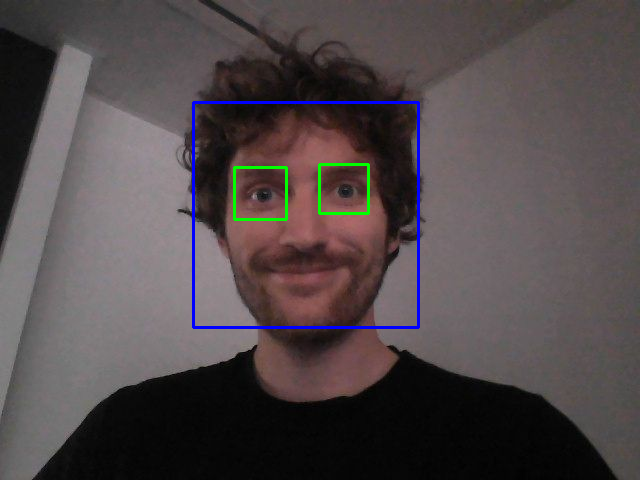

In [6]:
from google.colab.patches import cv2_imshow


cv2_imshow(faceimg)
cv2_imshow(img_show)

---

**YOLO**

In [7]:
from google.colab import drive
drive.mount('/content/drive')
# Drive contenant le modèle de Yolo

Mounted at /content/drive


In [8]:
WEIGHTS_PATH = "/content/drive/MyDrive/School_Of_AI_-_Photos_identite/model_weights/yolov3-wider_16000.weights"
CFG_PATH = "/content/drive/MyDrive/School_Of_AI_-_Photos_identite/cfg/yolov3-face.cfg"

IMG_WIDTH = 416
IMG_HEIGHT = 416
CONF_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3
## More about yolo threshold : https://medium.com/analytics-vidhya/you-only-look-once-yolo-implementing-yolo-in-less-than-30-lines-of-python-code-97fb9835bfd2


# Initialise Yolo

net = cv2.dnn.readNetFromDarknet(CFG_PATH, WEIGHTS_PATH)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def get_outs(img) :
    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(img, 1 / 255, (IMG_WIDTH, IMG_HEIGHT),
                                [0, 0, 0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(get_outputs_names(net))

    return img, outs



img, outs = get_outs(img)


# Remove the bounding boxes with low confidence
faces, left, top, right, bottom = post_process(img.copy(), outs, CONF_THRESHOLD, NMS_THRESHOLD)

img_log = img.copy()
draw_predict(img_log, left, top, right, bottom)



In [9]:
cv2_imshow(img_log)

Testons avec des images sur internet ?

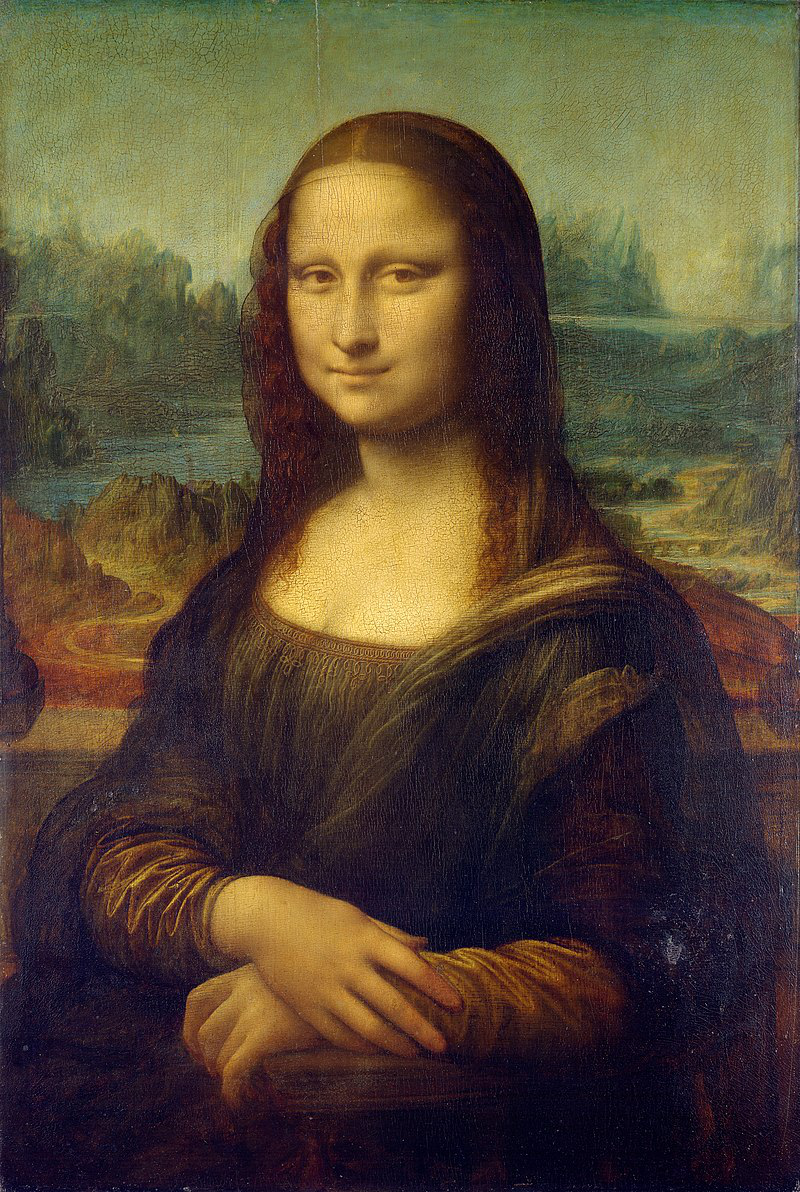

In [ ]:
from skimage import io

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/800px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg"

image = cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)
cv2_imshow(image)

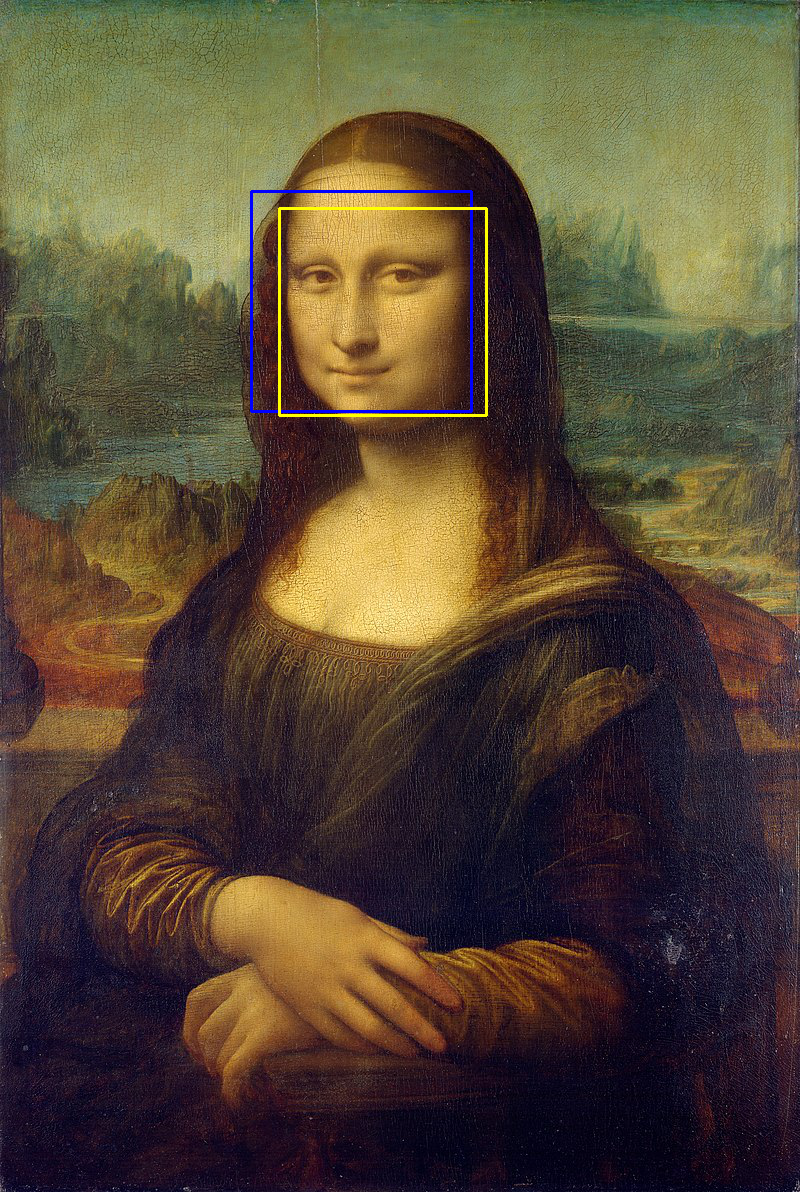

In [ ]:
faces = face_cascade.detectMultiScale(image.copy(), 1.1, FACE_SENSITIVITY, minSize=(100, 100))
eyes = eye_cascade.detectMultiScale(image.copy(), 1.1, EYE_SENSITIVITY, minSize=(10, 10))
if faces is None :
    faces = []
if eyes is None :
    eyes = []

### Tracage des objets

img_show = image.copy()
    
for (x, y, w, h) in faces:
    cv2.rectangle(img_show, (x,y), (x+w, y+h), (255,0,0), 2)
for (x, y, w, h) in eyes:
    cv2.rectangle(img_show, (x,y), (x+w, y+h), (0,255,0), 2)
# for (x, y, w, h) in mouthes:
#     cv2.rectangle(img_show, (x,y), (x+w, y+h), (0,0,255), 2)



image, outs = get_outs(image)


# Remove the bounding boxes with low confidence
faces, left, top, right, bottom = post_process(image.copy(), outs, CONF_THRESHOLD, NMS_THRESHOLD)

draw_predict(img_show, left, top, right, bottom)

cv2_imshow(img_show)